In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-maps-restaurants/google_maps_restaurants(cleaned).csv
/kaggle/input/mta-subway-hourly-2024-present/MTA_Subway_Hourly_Ridership__2020-2024_20260205.csv


In [14]:
import pandas as pd

# load restaurants
restaurants = pd.read_csv(
    "/kaggle/input/google-maps-restaurants/google_maps_restaurants(cleaned).csv"
)

# basic cleanup
restaurants = restaurants.rename(columns={
    "Lat": "latitude",
    "Lon": "longitude"
})

# filter to NYC (by bounding box – reliable)
restaurants = restaurants[
    (restaurants["latitude"] >= 40.49) & (restaurants["latitude"] <= 40.92) &
    (restaurants["longitude"] >= -74.26) & (restaurants["longitude"] <= -73.70)
]

# keep only useful columns
restaurants = restaurants[[
    "Name",
    "Rating",
    "Rating Count",
    "Price Category",
    "Address",
    "ZipCode",
    "latitude",
    "longitude"
]].dropna(subset=["latitude", "longitude"])

print("NYC restaurants:", restaurants.shape)
restaurants.head()


NYC restaurants: (670, 8)


,Name,Rating,Rating Count,Price Category,Address,ZipCode,latitude,longitude
0,The Firehouse Family Restaurant & Bar,4.6,549.0,1.0,"42 Plauderville Ave, Garfield, NJ 07026",7026,40.885012,-74.109239
1,H Restaurant & SS Restaurant,NaN,NaN,NaN,"510 S River St, Hackensack, NJ 07601",7601,40.863515,-74.035681
2,Joe's Restaurant,4.6,812.0,2.0,"6611 Forest Ave, Ridgewood, NY 11385",11385,40.707437,-73.903231
3,Mompou Tapas Bar & Restaurant,4.4,1136.0,2.0,"77 Ferry St, Newark, NJ 07105",7105,40.731355,-74.162045
4,Rasoi,3.9,1904.0,2.0,"810 Newark Ave, Jersey City, NJ 07306",7306,40.735757,-74.065378


In [15]:
# keep only NY zip codes (NYC zip codes start with 10–11)
restaurants_nyc = restaurants[
    restaurants["ZipCode"].astype(str).str.startswith(("10", "11"))
]

# drop rows with missing key info
restaurants_nyc = restaurants_nyc.dropna(
    subset=["latitude", "longitude", "Rating", "Rating Count"]
)

# reset index
restaurants_nyc = restaurants_nyc.reset_index(drop=True)

print("Clean NYC restaurants:", restaurants_nyc.shape)
restaurants_nyc.head()


Clean NYC restaurants: (343, 8)


,Name,Rating,Rating Count,Price Category,Address,ZipCode,latitude,longitude
0,Joe's Restaurant,4.6,812.0,2.0,"6611 Forest Ave, Ridgewood, NY 11385",11385,40.707437,-73.903231
1,Mexican Cantina Restaurant & Bar,4.5,257.0,2.0,"1736 Victory Blvd, Staten Island, NY 10314",10314,40.612941,-74.121610
2,Golden Krust Caribbean Restaurant,3.7,82.0,1.0,"1014a Nostrand Ave, Brooklyn, NY 11225",11225,40.663675,-73.951134
3,POLONICA RESTAURANT,4.5,227.0,2.0,"8303 3rd Ave, Brooklyn, NY 11209",11209,40.625481,-74.029996
4,Serafina Italian Restaurant Tribeca,4.3,1057.0,2.0,"95 W Broadway, New York, NY 10007",10007,40.715587,-74.008876


In [24]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree

# load MTA ridership data
mta = pd.read_csv(
    "/kaggle/input/mta-subway-hourly-2024-present/MTA_Subway_Hourly_Ridership__2020-2024_20260205.csv"
)

# ensure numeric
mta["ridership"] = pd.to_numeric(mta["ridership"], errors="coerce").fillna(0)

# aggregate to station-level
stations = (
    mta
    .groupby(["station_complex", "latitude", "longitude"], as_index=False)
    .agg(total_ridership=("ridership", "sum"))
    .rename(columns={"station_complex": "station_name"})
)

print("Stations:", stations.shape)

# load and clean restaurant data
restaurants = pd.read_csv(
    "/kaggle/input/google-maps-restaurants/google_maps_restaurants(cleaned).csv"
)

restaurants = restaurants.rename(columns={"Lat": "latitude", "Lon": "longitude"})

# NYC bounding box
restaurants = restaurants[
    (restaurants["latitude"].between(40.49, 40.92)) &
    (restaurants["longitude"].between(-74.26, -73.70))
]

# keep only NYC zip codes + valid rows
restaurants_nyc = (
    restaurants[
        restaurants["ZipCode"].astype(str).str.startswith(("10", "11"))
    ]
    .dropna(subset=["latitude", "longitude", "Rating", "Rating Count"])
    .reset_index(drop=True)
)

print("NYC restaurants:", restaurants_nyc.shape)

# match each restaurant to nearest subway station
stations_rad = np.radians(stations[["latitude", "longitude"]].values)
restaurants_rad = np.radians(restaurants_nyc[["latitude", "longitude"]].values)

tree = BallTree(stations_rad, metric="haversine")

distances, indices = tree.query(restaurants_rad, k=1)

EARTH_RADIUS_M = 6_371_000

restaurants_nyc["nearest_station"] = stations.iloc[indices.flatten()]["station_name"].values
restaurants_nyc["distance_to_station_m"] = distances.flatten() * EARTH_RADIUS_M
restaurants_nyc["total_ridership"] = stations.iloc[indices.flatten()]["total_ridership"].values

# compute busyness score (deterministic)
restaurants_nyc["busyness_score"] = (
    restaurants_nyc["total_ridership"] /
    (restaurants_nyc["distance_to_station_m"] + 50)
)

# inspect results
restaurants_nyc[
    ["Name", "nearest_station", "total_ridership", "distance_to_station_m", "busyness_score"]
].sort_values("busyness_score", ascending=False).head(10)


Stations: (444, 4)
NYC restaurants: (343, 10)


,Name,nearest_station,total_ridership,distance_to_station_m,busyness_score
89,Chelsea Ristorante Italiano,"14 St (A,C,E)/8 Av (L)",961.0,28.217803,12.286205
342,Family Meal at Blue Hill,"W 4 St-Wash Sq (A,C,E,B,D,F,M)",1189.0,76.890915,9.370253
11,Oceana,"47-50 Sts-Rockefeller Ctr (B,D,F,M)",1694.0,147.538808,8.575530
92,Astro,57 St (F),1216.0,106.867020,7.751789
143,Clark's Restaurant,"Clark St (2,3)",427.0,13.491181,6.725343
129,Connolly's,"47-50 Sts-Rockefeller Ctr (B,D,F,M)",1694.0,237.991999,5.882108
254,Som Bo,"14 St (A,C,E)/8 Av (L)",961.0,115.213900,5.816702
19,Benares,"Chambers St (A,C)/WTC (E)/Park Pl (2,3)/Cortla...",573.0,53.153524,5.554827
38,Guantanamera,"57 St-7 Av (N,Q,R,W)",1750.0,299.138804,5.012333
337,Le Coucou,"Canal St (J,N,Q,R,W,Z,6)",448.0,52.294789,4.379500


In [25]:
import folium
from folium.plugins import HeatMap

# center map NYC
nyc_map = folium.Map(location=[40.75, -73.98], zoom_start=12)

# heatmap load
heat_data = restaurants_nyc[[
    "latitude",
    "longitude",
    "busyness_score"
]].values.tolist()

# add heatmap
HeatMap(
    heat_data,
    radius=15,
    blur=20,
    max_zoom=13
).add_to(nyc_map)

nyc_map


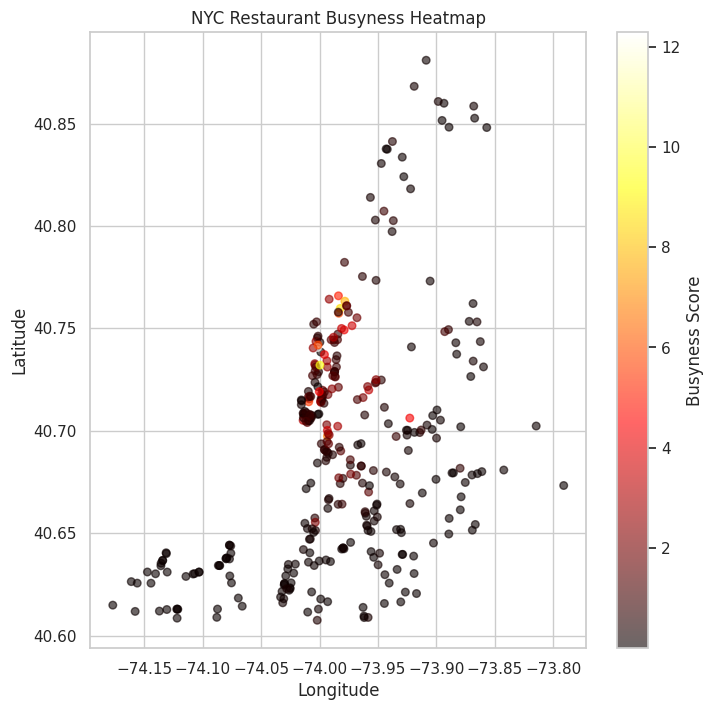

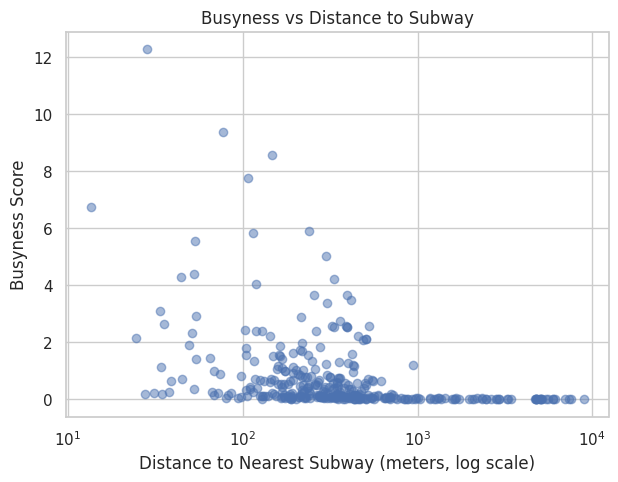

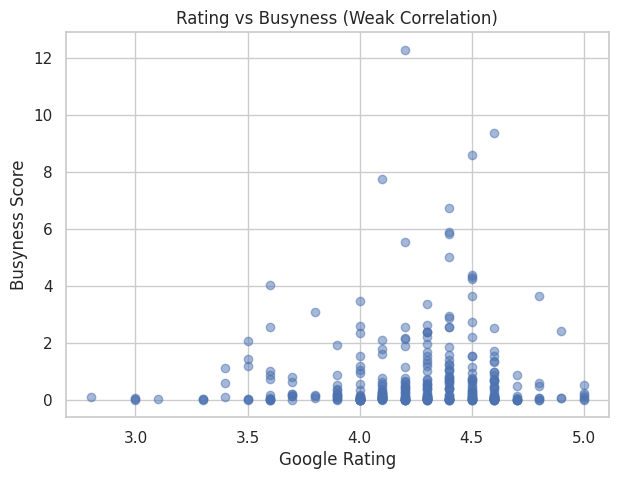

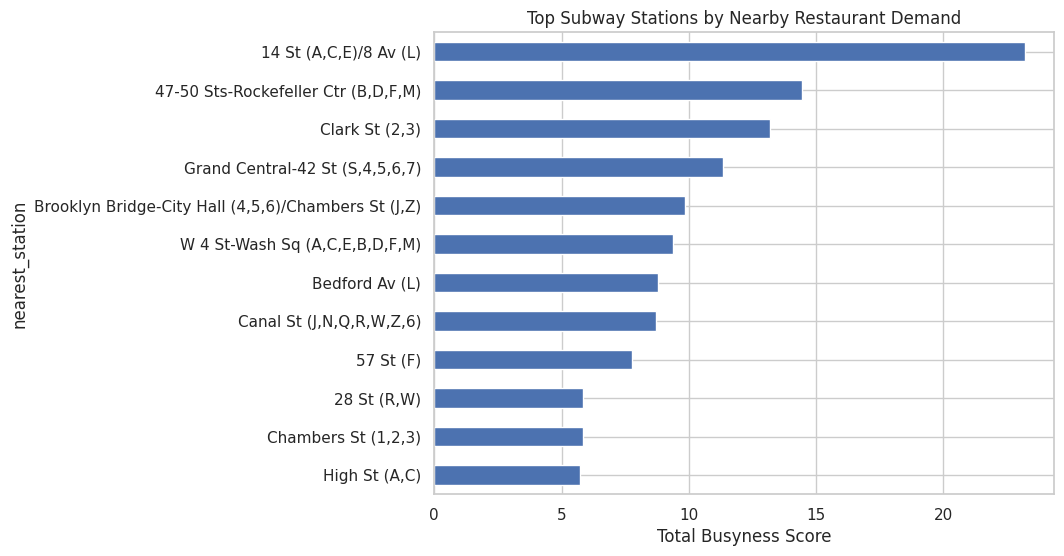

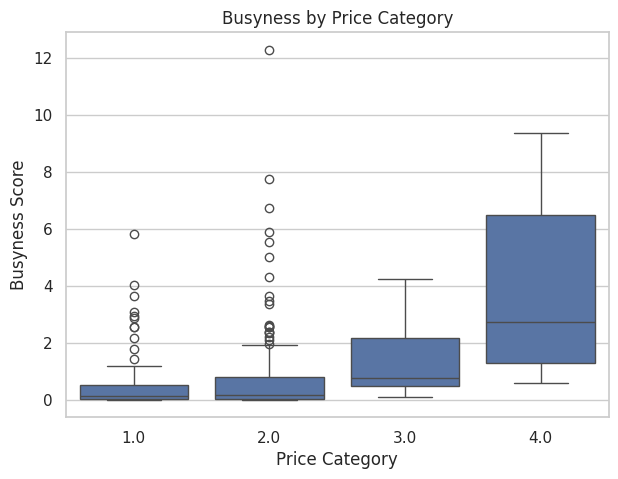

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. Busyness Heatmap (spatial)
plt.figure(figsize=(8, 8))
plt.scatter(
    restaurants_nyc["longitude"],
    restaurants_nyc["latitude"],
    c=restaurants_nyc["busyness_score"],
    cmap="hot",
    s=30,
    alpha=0.6
)
plt.colorbar(label="Busyness Score")
plt.title("NYC Restaurant Busyness Heatmap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


# 2. Distance to Subway vs Busyness
plt.figure(figsize=(7, 5))
plt.scatter(
    restaurants_nyc["distance_to_station_m"],
    restaurants_nyc["busyness_score"],
    alpha=0.5
)
plt.xscale("log")
plt.xlabel("Distance to Nearest Subway (meters, log scale)")
plt.ylabel("Busyness Score")
plt.title("Busyness vs Distance to Subway")
plt.show()


# 3. Rating vs Busyness
plt.figure(figsize=(7, 5))
plt.scatter(
    restaurants_nyc["Rating"],
    restaurants_nyc["busyness_score"],
    alpha=0.5
)
plt.xlabel("Google Rating")
plt.ylabel("Busyness Score")
plt.title("Rating vs Busyness (Weak Correlation)")
plt.show()


# 4. Top Stations by Total Busyness
top_stations = (
    restaurants_nyc
    .groupby("nearest_station")["busyness_score"]
    .sum()
    .sort_values(ascending=False)
    .head(12)
)

plt.figure(figsize=(8, 6))
top_stations.sort_values().plot(kind="barh")
plt.xlabel("Total Busyness Score")
plt.title("Top Subway Stations by Nearby Restaurant Demand")
plt.show()


# 5. Price Category vs Busyness
plt.figure(figsize=(7, 5))
sns.boxplot(
    x="Price Category",
    y="busyness_score",
    data=restaurants_nyc
)
plt.xlabel("Price Category")
plt.ylabel("Busyness Score")
plt.title("Busyness by Price Category")
plt.show()



In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

# select features + target
features = [
    "total_ridership",
    "distance_to_station_m",
    "Rating",
    "Rating Count",
    "Price Category"
]

# drop rows with missing values
model_df = restaurants_nyc[features + ["busyness_score"]].dropna()

X = model_df[features]
y = model_df["busyness_score"]

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# train model
model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

model.fit(X_train, y_train)

# evaluate
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))


MAE: 0.11034397228157045
